In [129]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    ConfusionMatrixDisplay,
)
from sklearn import set_config

In [130]:
set_config(transform_output="pandas")

# Load the data

In [270]:
df = pd.read_csv("../data/customer_churn_processed_data.csv")
df.head()

,creditscore,country,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,france,female,42,2,0.00,1,1,1,101348.88,1
1,608,spain,female,41,1,83807.86,1,0,1,112542.58,0
2,502,france,female,42,8,159660.80,3,1,0,113931.57,1
3,699,france,female,39,1,0.00,2,0,0,93826.63,0
4,850,spain,female,43,2,125510.82,1,1,1,79084.10,0


In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   creditscore      10000 non-null  int64  
 1   country          10000 non-null  object 
 2   gender           10000 non-null  object 
 3   age              10000 non-null  int64  
 4   tenure           10000 non-null  int64  
 5   balance          10000 non-null  float64
 6   numofproducts    10000 non-null  int64  
 7   hascrcard        10000 non-null  int64  
 8   isactivemember   10000 non-null  int64  
 9   estimatedsalary  10000 non-null  float64
 10  exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


### Split the data

In [133]:
X = df.drop("exited", axis=1)
y = df["exited"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [266]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, sep="\n")

(8000, 10)
(8000,)
(2000, 10)
(2000,)


In [267]:
y_train.value_counts(normalize=True)

exited
0    0.79625
1    0.20375
Name: proportion, dtype: float64

In [268]:
y_test.value_counts(normalize=True)

exited
0    0.7965
1    0.2035
Name: proportion, dtype: float64

### Define categorical transformer

In [269]:
category_transformer = ColumnTransformer(
    [
        (
            "cat_encoder",
            OneHotEncoder(sparse_output=False, drop="if_binary"),
            ["country", "gender"],
        )
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
)

### Define utility functions and tables

In [255]:
def get_errors(model, X, y):
    """Computes the error metrics for evaluating a classification model."""

    preds = model.predict(X)
    accuracy = accuracy_score(y, preds)
    recall = recall_score(y, preds)
    precision = precision_score(y, preds, zero_division=0.0)
    return {"accuracy": accuracy, "recall": recall, "precision": precision}


def get_avg_cv_errors(cv_result):
    """Get the average value of the error metrics from the cross validation result."""

    return {
        "accuracy": cv_result["test_accuracy"].mean(),
        "recall": cv_result["test_recall"].mean(),
        "precision": cv_result["test_precision"].mean(),
    }


def plot_confusion_matrix(model, model_name, X, y, split="test"):
    """Plot the confusion matrix of a classification model."""

    ConfusionMatrixDisplay.from_estimator(model, X, y)
    plt.title(f"Confusion Matrix of {model_name} Model [{split.title()} Set]")


def log_error(model_name, errors, eval_set, perf_df):
    """Store the performance metrics of a model."""

    cols = [eval_set + "_" + err for err in ("accuracy", "recall", "precision")]
    perf_df.loc[model_name, cols] = list(errors)

In [257]:
perf_df = pd.DataFrame(
    columns=[
        "train_accuracy",
        "train_recall",
        "train_precision",
        "cv_accuracy",
        "cv_recall",
        "cv_precision",
        "test_accuracy",
        "test_recall",
        "test_precision"
    ]
)

### Build and Evaluate Baseline Model

In [258]:
base_model = DummyClassifier()  # Instantiate the model
base_model.fit(X_train, y_train)  # Train the model

,strategy,'prior'
,random_state,None
,constant,None


In [259]:
train_pred = base_model.predict(X_train)  # Generate train prediction

In [260]:
train_pred[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [261]:
# Evaluate training predictions

base_train_errors = get_errors(base_model, X_train, y_train)
base_train_errors

{'accuracy': 0.79625, 'recall': 0.0, 'precision': 0.0}

In [144]:
# Log train error
log_error("Base Model", base_train_errors.values(), "train", perf_df)

In [145]:
perf_df

,train_accuracy,train_recall,train_precision,cv_accuracy,cv_recall,cv_precision,test_accuracy,test_recall,test_precision
Base Model,0.79625,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


#### Get cross validation error

In [262]:
cv_results = cross_validate(base_model, X_train, y_train, cv=5, scoring=get_errors)

In [148]:
base_avg_cv_errors = get_avg_cv_errors(cv_results)
base_avg_cv_errors

{'accuracy': np.float64(0.79625),
 'recall': np.float64(0.0),
 'precision': np.float64(0.0)}

In [149]:
log_error("Base Model", base_avg_cv_errors.values(), "cv", perf_df)

In [150]:
perf_df

,train_accuracy,train_recall,train_precision,cv_accuracy,cv_recall,cv_precision,test_accuracy,test_recall,test_precision
Base Model,0.79625,0.0,0.0,0.79625,0.0,0.0,NaN,NaN,NaN


#### Evaluate model on test set

In [151]:
test_pred = base_model.predict(X_test)

In [152]:
base_test_errors = get_errors(base_model, X_test, y_test)
base_test_errors

{'accuracy': 0.7965, 'recall': 0.0, 'precision': 0.0}

#### Save base model error

In [153]:
log_error("Base Model", base_test_errors.values(), "test", perf_df)

In [154]:
perf_df

,train_accuracy,train_recall,train_precision,cv_accuracy,cv_recall,cv_precision,test_accuracy,test_recall,test_precision
Base Model,0.79625,0.0,0.0,0.79625,0.0,0.0,0.7965,0.0,0.0


### Plot base model confusion matrix

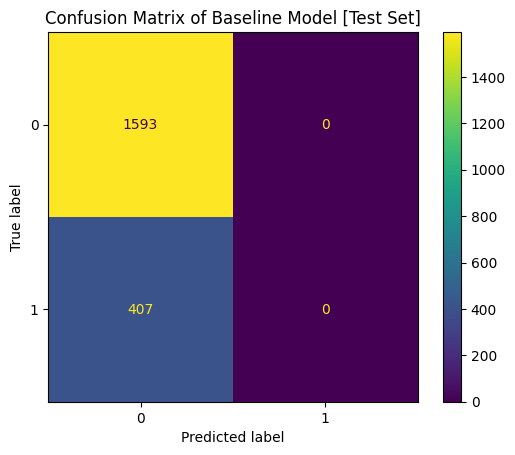

In [264]:
plot_confusion_matrix(base_model, "Baseline", X_test, y_test)

### Build and Evaluate Logistic Regression Model

In [156]:
lr_model = LogisticRegression(max_iter=20000)

In [157]:
lr_pipeline = make_pipeline(category_transformer, lr_model)

Train the model

In [265]:
lr_pipeline.fit(X_train, y_train)

,steps,"[('columntransformer', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat_encoder', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


Evaluate the model

In [159]:
train_preds = lr_pipeline.predict(X_train)

In [160]:
lr_train_errors = get_errors(lr_pipeline, X_train, y_train)
lr_train_errors

{'accuracy': 0.81,
 'recall': 0.2134969325153374,
 'precision': 0.5938566552901023}

Get cross validation result

In [161]:
cv_results = cross_validate(lr_pipeline, X_train, y_train, cv=5, scoring=get_errors)

In [162]:
lr_avg_cv_errors = get_avg_cv_errors(cv_results)
lr_avg_cv_errors

{'accuracy': np.float64(0.810375),
 'recall': np.float64(0.21595092024539878),
 'precision': np.float64(0.5961013026454431)}

Evaluate the model on the test set

In [163]:
lr_test_errors = get_errors(lr_pipeline, X_test, y_test)
lr_test_errors

{'accuracy': 0.8085, 'recall': 0.18673218673218672, 'precision': 0.59375}

#### Log errors

In [164]:
log_error("LR Model", lr_train_errors.values(), "train", perf_df)
log_error("LR Model", lr_avg_cv_errors.values(), "cv", perf_df)
log_error("LR Model", lr_test_errors.values(), "test", perf_df)

In [165]:
perf_df

,train_accuracy,train_recall,train_precision,cv_accuracy,cv_recall,cv_precision,test_accuracy,test_recall,test_precision
Base Model,0.79625,0.0,0.0,0.79625,0.0,0.0,0.7965,0.0,0.0
LR Model,0.81,0.213497,0.593857,0.810375,0.215951,0.596101,0.8085,0.186732,0.59375


### Plot LR model confusion matrix

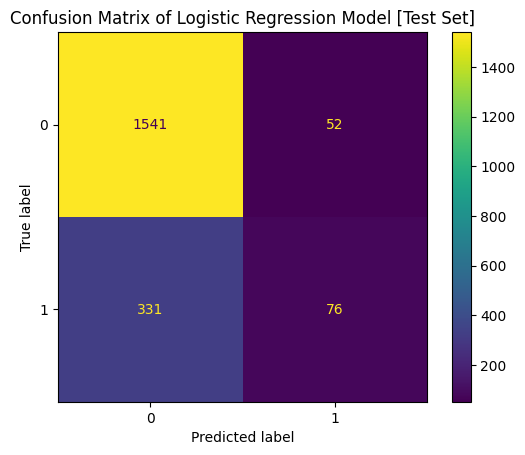

In [166]:
plot_confusion_matrix(lr_pipeline, "Logistic Regression", X_test, y_test)

### Build and Evaluate Decision Tree Model

#### Build the model

In [167]:
# Instantiate the model

dt_model = DecisionTreeClassifier(random_state=42)

In [168]:
# Create pipeline

dt_pipeline = make_pipeline(category_transformer, dt_model)
dt_pipeline.fit(X_train, y_train)

,steps,"[('columntransformer', ...), ('decisiontreeclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat_encoder', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


#### Handle the overfitting issue in the decision tree

In [169]:
# Check the tree's depth

dt_pipeline[-1].get_depth()

24

#### Find the optimal tree depth with grid search cv

In [170]:
param_grid = {"decisiontreeclassifier__max_depth": range(2, 24)}

grid_search_cv = GridSearchCV(
    dt_pipeline, param_grid=param_grid,
    scoring=["accuracy", "recall", "precision"], refit="recall",
    return_train_score=True
)
grid_search_cv.fit(X_train, y_train)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'decisiontreeclassifier__max_depth': range(2, 24)}"
,scoring,"['accuracy', 'recall', ...]"
,n_jobs,None
,refit,'recall'
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,transformers,"[('cat_encoder', ...)]"


In [171]:
cv_results = pd.DataFrame(grid_search_cv.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_decisiontreeclassifier__max_depth,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,...,mean_test_precision,std_test_precision,rank_test_precision,split0_train_precision,split1_train_precision,split2_train_precision,split3_train_precision,split4_train_precision,mean_train_precision,std_train_precision
0,0.023902,0.001876,0.016086,0.001566,2,{'decisiontreeclassifier__max_depth': 2},0.824375,0.841875,0.821250,0.827500,...,0.626467,0.045625,8,0.615385,0.681404,0.615957,0.611828,0.603854,0.625686,0.028192
1,0.028121,0.004672,0.019133,0.004269,3,{'decisiontreeclassifier__max_depth': 3},0.843750,0.846250,0.833125,0.836875,...,0.790784,0.059099,1,0.844498,0.693548,0.862233,0.804554,0.865285,0.814024,0.064007
2,0.028593,0.000556,0.016006,0.001008,4,{'decisiontreeclassifier__max_depth': 4},0.848125,0.853750,0.839375,0.838750,...,0.768770,0.040963,4,0.808696,0.794408,0.813559,0.780186,0.737430,0.786856,0.027329
3,0.036386,0.003686,0.018927,0.002867,5,{'decisiontreeclassifier__max_depth': 5},0.848125,0.856875,0.842500,0.840625,...,0.782458,0.057202,3,0.887295,0.810726,0.781818,0.788352,0.780664,0.809771,0.040245
4,0.067785,0.014360,0.034344,0.011857,6,{'decisiontreeclassifier__max_depth': 6},0.852500,0.870000,0.843750,0.841875,...,0.782881,0.041155,2,0.839063,0.830133,0.840841,0.830460,0.780178,0.824135,0.022406


In [172]:
cv_cols = [
    "param_decisiontreeclassifier__max_depth",
    "mean_test_recall",
    "std_test_recall",
    "mean_train_recall",
    "std_train_recall",
    "rank_test_recall",
    "mean_test_accuracy",
    "mean_train_accuracy",
    "mean_test_precision",
    "mean_train_precision",
]

In [173]:
cv_results_subset = cv_results[cv_cols].sort_values(["rank_test_recall", "std_test_recall"])

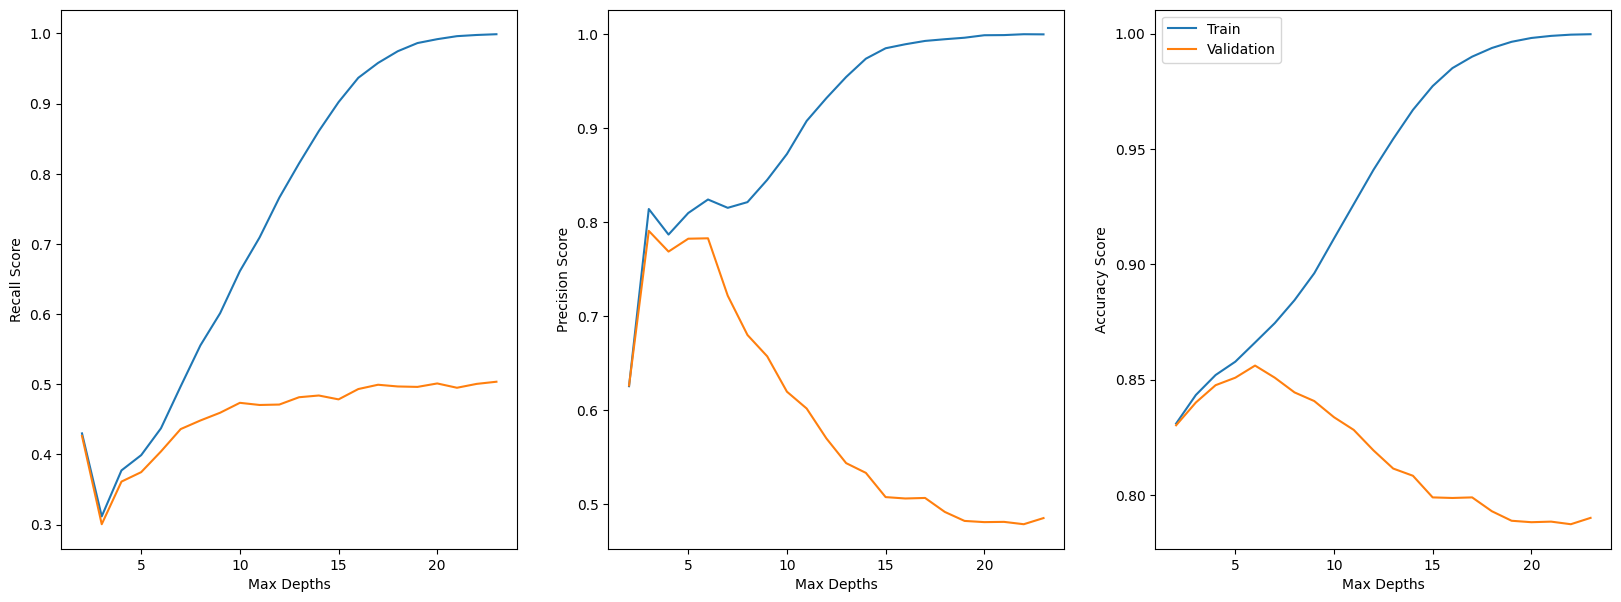

In [174]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))

ax1.plot(cv_results["param_decisiontreeclassifier__max_depth"], cv_results["mean_train_recall"], label="Train")
ax1.plot(cv_results["param_decisiontreeclassifier__max_depth"], cv_results["mean_test_recall"], label="Validation")
ax1.set_xlabel("Max Depths")
ax1.set_ylabel("Recall Score")

ax2.plot(cv_results["param_decisiontreeclassifier__max_depth"], cv_results["mean_train_precision"], label="Train")
ax2.plot(cv_results["param_decisiontreeclassifier__max_depth"], cv_results["mean_test_precision"], label="Validation")
ax2.set_xlabel("Max Depths")
ax2.set_ylabel("Precision Score")

ax3.plot(cv_results["param_decisiontreeclassifier__max_depth"], cv_results["mean_train_accuracy"], label="Train")
ax3.plot(cv_results["param_decisiontreeclassifier__max_depth"], cv_results["mean_test_accuracy"], label="Validation")
ax3.set_xlabel("Max Depths")
ax3.set_ylabel("Accuracy Score")
plt.legend();

In [175]:
cv_results_subset.set_index("param_decisiontreeclassifier__max_depth").loc[[5, 6, 7, 8]]

,mean_test_recall,std_test_recall,mean_train_recall,std_train_recall,rank_test_recall,mean_test_accuracy,mean_train_accuracy,mean_test_precision,mean_train_precision
param_decisiontreeclassifier__max_depth,,,,,,,,,
5,0.374847,0.035317,0.399080,0.035626,20,0.850875,0.857812,0.782458,0.809771
6,0.404294,0.052288,0.437270,0.019560,19,0.856125,0.866125,0.782881,0.824135
7,0.436196,0.028736,0.497086,0.009909,17,0.850875,0.874531,0.721900,0.815286
8,0.448466,0.048710,0.555521,0.027077,16,0.844500,0.884469,0.680113,0.821352


We choose the best max depth as 6 because it is optimal for both accuracy and precision at that point. If we choose the max depth for the best average recall on the validation set, we would the be overfitting the other metrics.

#### Retrain the model with max_depth of 6

In [176]:
# Instantiate the model

dt_model = DecisionTreeClassifier(max_depth=6, random_state=42)

In [177]:
# Create pipeline

dt_pipeline = make_pipeline(category_transformer, dt_model)
dt_pipeline.fit(X_train, y_train)

,steps,"[('columntransformer', ...), ('decisiontreeclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat_encoder', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


#### Evaluate the training set

In [178]:
dt6_train_errors = get_errors(dt_pipeline, X_train, y_train)
dt6_train_errors

{'accuracy': 0.868125,
 'recall': 0.45950920245398774,
 'precision': 0.8114842903575298}

#### Cross validate

In [179]:
cv_results = cross_validate(dt_pipeline, X_train, y_train, cv=5, scoring=["accuracy", "recall", "precision"], n_jobs=-1)
dt6_avg_cv_errors = get_avg_cv_errors(cv_results)
dt6_avg_cv_errors

{'accuracy': np.float64(0.8561250000000001),
 'recall': np.float64(0.40429447852760736),
 'precision': np.float64(0.7828812283541768)}

#### Evaluate on test

In [180]:
dt6_test_errors = get_errors(dt_pipeline, X_test, y_test)
dt6_test_errors

{'accuracy': 0.8595,
 'recall': 0.44226044226044225,
 'precision': 0.7692307692307693}

#### Log errors

In [181]:
log_error("DT Model", dt6_train_errors.values(), "train", perf_df)
log_error("DT Model", dt6_avg_cv_errors.values(), "cv", perf_df)
log_error("DT Model", dt6_test_errors.values(), "test", perf_df)

In [182]:
perf_df

,train_accuracy,train_recall,train_precision,cv_accuracy,cv_recall,cv_precision,test_accuracy,test_recall,test_precision
Base Model,0.79625,0.0,0.0,0.79625,0.0,0.0,0.7965,0.0,0.0
LR Model,0.81,0.213497,0.593857,0.810375,0.215951,0.596101,0.8085,0.186732,0.59375
DT Model,0.868125,0.459509,0.811484,0.856125,0.404294,0.782881,0.8595,0.44226,0.769231


### Plot DT model confusion matrix

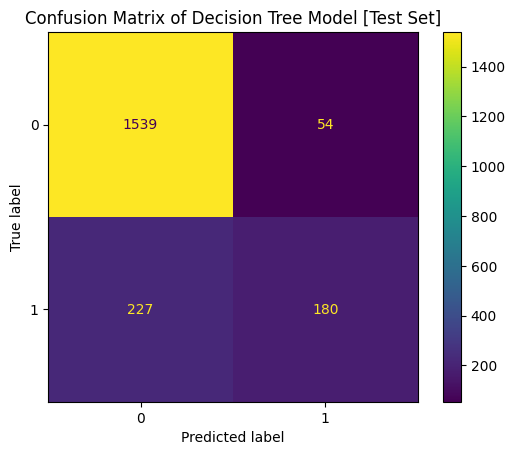

In [183]:
plot_confusion_matrix(dt_pipeline, "Decision Tree", X_test, y_test)

### Random Forest

#### Build the model

In [184]:
# Instantiate the model

rf_model = RandomForestClassifier(max_depth=6, random_state=42)

In [185]:
# Create pipeline

rf_pipeline = make_pipeline(category_transformer, rf_model)
rf_pipeline.fit(X_train, y_train)

,steps,"[('columntransformer', ...), ('randomforestclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat_encoder', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


#### Evaluate the training set

In [186]:
rf_train_errors = get_errors(rf_pipeline, X_train, y_train)
rf_train_errors

{'accuracy': 0.867,
 'recall': 0.3993865030674847,
 'precision': 0.8845108695652174}

#### Evaluate with cross validation

In [187]:
cv_results = cross_validate(rf_pipeline, X_train, y_train, scoring=["accuracy", "precision", "recall"], cv=5)
rf_avg_cv_errors = get_avg_cv_errors(cv_results)
rf_avg_cv_errors

{'accuracy': np.float64(0.8578749999999999),
 'recall': np.float64(0.38343558282208584),
 'precision': np.float64(0.8268908821453659)}

#### Evaluate on test

In [188]:
rf_test_errors = get_errors(rf_pipeline, X_test, y_test)
rf_test_errors

{'accuracy': 0.8605,
 'recall': 0.37346437346437344,
 'precision': 0.8636363636363636}

#### Log errors

In [189]:
log_error("RF Model", rf_train_errors.values(), "train", perf_df)
log_error("RF Model", rf_avg_cv_errors.values(), "cv", perf_df)
log_error("RF Model", rf_test_errors.values(), "test", perf_df)

In [190]:
perf_df

,train_accuracy,train_recall,train_precision,cv_accuracy,cv_recall,cv_precision,test_accuracy,test_recall,test_precision
Base Model,0.79625,0.0,0.0,0.79625,0.0,0.0,0.7965,0.0,0.0
LR Model,0.81,0.213497,0.593857,0.810375,0.215951,0.596101,0.8085,0.186732,0.59375
DT Model,0.868125,0.459509,0.811484,0.856125,0.404294,0.782881,0.8595,0.44226,0.769231
RF Model,0.867,0.399387,0.884511,0.857875,0.383436,0.826891,0.8605,0.373464,0.863636


### Plot RF model confusion matrix

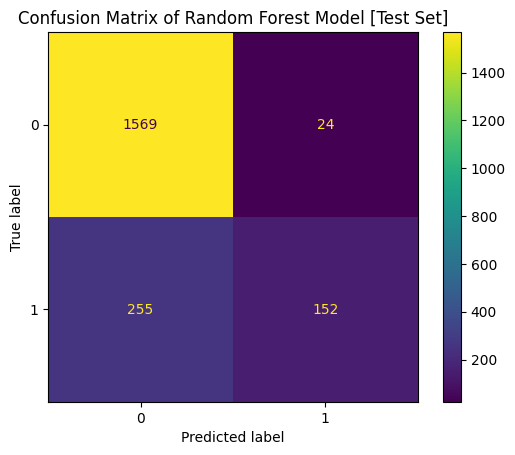

In [191]:
plot_confusion_matrix(rf_pipeline, "Random Forest", X_test, y_test)

### Gradient Boosting

#### Build the model

In [271]:
# Instantiate the model

gb_model = GradientBoostingClassifier(max_depth=6, random_state=42)

In [272]:
# Create pipeline

gb_pipeline = make_pipeline(category_transformer, gb_model)
gb_pipeline.fit(X_train, y_train)

,steps,"[('columntransformer', ...), ('gradientboostingclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat_encoder', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


#### Evaluate the training set

In [194]:
gb_train_errors = get_errors(gb_pipeline, X_train, y_train)
gb_train_errors

{'accuracy': 0.923625,
 'recall': 0.6723926380368098,
 'precision': 0.9343563512361467}

#### Evaluate with cross validation

In [195]:
cv_results = cross_validate(gb_pipeline, X_train, y_train, scoring=["accuracy", "precision", "recall"], cv=5)
gb_avg_cv_errors = get_avg_cv_errors(cv_results)
gb_avg_cv_errors

{'accuracy': np.float64(0.859875),
 'recall': np.float64(0.47975460122699387),
 'precision': np.float64(0.7420636051761955)}

#### Evaluate on test

In [196]:
gb_test_errors = get_errors(gb_pipeline, X_test, y_test)
gb_test_errors

{'accuracy': 0.8625, 'recall': 0.47665847665847666, 'precision': 0.7578125}

#### Log errors

In [197]:
log_error("GB Model", gb_train_errors.values(), "train", perf_df)
log_error("GB Model", gb_avg_cv_errors.values(), "cv", perf_df)
log_error("GB Model", gb_test_errors.values(), "test", perf_df)

In [198]:
perf_df

,train_accuracy,train_recall,train_precision,cv_accuracy,cv_recall,cv_precision,test_accuracy,test_recall,test_precision
Base Model,0.79625,0.0,0.0,0.79625,0.0,0.0,0.7965,0.0,0.0
LR Model,0.81,0.213497,0.593857,0.810375,0.215951,0.596101,0.8085,0.186732,0.59375
DT Model,0.868125,0.459509,0.811484,0.856125,0.404294,0.782881,0.8595,0.44226,0.769231
RF Model,0.867,0.399387,0.884511,0.857875,0.383436,0.826891,0.8605,0.373464,0.863636
GB Model,0.923625,0.672393,0.934356,0.859875,0.479755,0.742064,0.8625,0.476658,0.757812


## Find the optimal learning rate for the GB model

In [199]:
param_grid = {"gradientboostingclassifier__learning_rate": np.linspace(0.01, 0.1, 10)}

grid_search_cv = GridSearchCV(
    gb_pipeline,
    param_grid=param_grid,
    scoring=["accuracy", "recall", "precision"],
    return_train_score=True,
    refit="recall",
    n_jobs=-1,
)
grid_search_cv.fit(X_train, y_train)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'gradientboostingclassifier__learning_rate': array([0.01, ..., 0.09, 0.1 ])}"
,scoring,"['accuracy', 'recall', ...]"
,n_jobs,-1
,refit,'recall'
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,transformers,"[('cat_encoder', ...)]"


In [273]:
cv_results = pd.DataFrame(grid_search_cv.cv_results_)

In [274]:
cv_cols = [
    "param_gradientboostingclassifier__learning_rate",
    "mean_test_recall",
    "mean_train_recall",
    "rank_test_recall",
    "mean_test_accuracy",
    "mean_train_accuracy",
    "mean_test_precision",
    "mean_train_precision",
]
cv_results_subset = cv_results[cv_cols].sort_values(["rank_test_recall"])

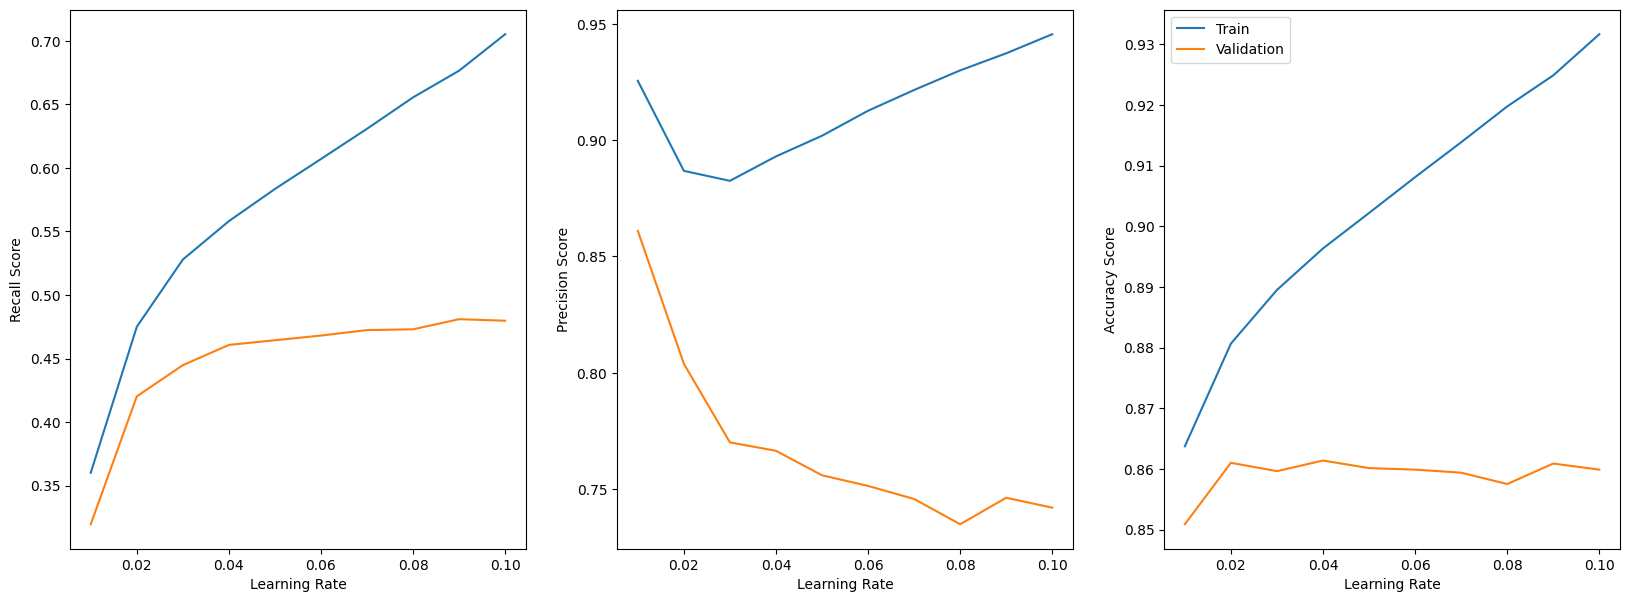

In [275]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))

ax1.plot(cv_results["param_gradientboostingclassifier__learning_rate"], cv_results["mean_train_recall"], label="Train")
ax1.plot(cv_results["param_gradientboostingclassifier__learning_rate"], cv_results["mean_test_recall"], label="Validation")
ax1.set_xlabel("Learning Rate")
ax1.set_ylabel("Recall Score")

ax2.plot(cv_results["param_gradientboostingclassifier__learning_rate"], cv_results["mean_train_precision"], label="Train")
ax2.plot(cv_results["param_gradientboostingclassifier__learning_rate"], cv_results["mean_test_precision"], label="Validation")
ax2.set_xlabel("Learning Rate")
ax2.set_ylabel("Precision Score")

ax3.plot(cv_results["param_gradientboostingclassifier__learning_rate"], cv_results["mean_train_accuracy"], label="Train")
ax3.plot(cv_results["param_gradientboostingclassifier__learning_rate"], cv_results["mean_test_accuracy"], label="Validation")
ax3.set_xlabel("Learning Rate")
ax3.set_ylabel("Accuracy Score")
plt.legend();

In [276]:
cv_results_subset.sort_values("param_gradientboostingclassifier__learning_rate")

,param_gradientboostingclassifier__learning_rate,mean_test_recall,mean_train_recall,rank_test_recall,mean_test_accuracy,mean_train_accuracy,mean_test_precision,mean_train_precision
0,0.01,0.319632,0.360123,10,0.850875,0.863719,0.861005,0.925488
1,0.02,0.420245,0.475000,9,0.861000,0.880656,0.803909,0.886796
2,0.03,0.444785,0.527914,8,0.859625,0.889500,0.770108,0.882506
3,0.04,0.460736,0.558129,7,0.861375,0.896344,0.766500,0.892998
4,0.05,0.464417,0.583436,6,0.860125,0.902187,0.755984,0.901879
5,0.06,0.468098,0.607055,5,0.859875,0.908094,0.751409,0.912613
6,0.07,0.472393,0.630828,4,0.859375,0.913844,0.745798,0.921537
7,0.08,0.473006,0.655521,3,0.857500,0.919750,0.734950,0.929960
8,0.09,0.480982,0.676534,1,0.860875,0.924875,0.746319,0.937298
9,0.10,0.479755,0.705215,2,0.859875,0.931656,0.742064,0.945506


#### Retrain the model with learning rate of 0.02

In [277]:
# Instantiate the model

gb_model = GradientBoostingClassifier(max_depth=6, learning_rate=0.02, random_state=42)

In [278]:
# Create pipeline

gb_pipeline = make_pipeline(category_transformer, gb_model)
gb_pipeline.fit(X_train, y_train)

,steps,"[('columntransformer', ...), ('gradientboostingclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat_encoder', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


#### Evaluate the training set

In [206]:
gb_train_errors = get_errors(gb_pipeline, X_train, y_train)
gb_train_errors

{'accuracy': 0.878375,
 'recall': 0.4662576687116564,
 'precision': 0.880648899188876}

#### Evaluate with cross validation

In [207]:
cv_results = cross_validate(gb_pipeline, X_train, y_train, scoring=["accuracy", "precision", "recall"], cv=5)
gb_avg_cv_errors = get_avg_cv_errors(cv_results)
gb_avg_cv_errors

{'accuracy': np.float64(0.861),
 'recall': np.float64(0.41963190184049076),
 'precision': np.float64(0.8047383744924369)}

#### Evaluate on test

In [208]:
gb_test_errors = get_errors(gb_pipeline, X_test, y_test)
gb_test_errors

{'accuracy': 0.866,
 'recall': 0.4176904176904177,
 'precision': 0.845771144278607}

#### Log errors

In [209]:
log_error("Opt GB Model", gb_train_errors.values(), "train", perf_df)
log_error("Opt GB Model", gb_avg_cv_errors.values(), "cv", perf_df)
log_error("Opt GB Model", gb_test_errors.values(), "test", perf_df)

In [210]:
perf_df

,train_accuracy,train_recall,train_precision,cv_accuracy,cv_recall,cv_precision,test_accuracy,test_recall,test_precision
Base Model,0.79625,0.0,0.0,0.79625,0.0,0.0,0.7965,0.0,0.0
LR Model,0.81,0.213497,0.593857,0.810375,0.215951,0.596101,0.8085,0.186732,0.59375
DT Model,0.868125,0.459509,0.811484,0.856125,0.404294,0.782881,0.8595,0.44226,0.769231
RF Model,0.867,0.399387,0.884511,0.857875,0.383436,0.826891,0.8605,0.373464,0.863636
GB Model,0.923625,0.672393,0.934356,0.859875,0.479755,0.742064,0.8625,0.476658,0.757812
Opt GB Model,0.878375,0.466258,0.880649,0.861,0.419632,0.804738,0.866,0.41769,0.845771


### Plot optimal GB confusion matrix

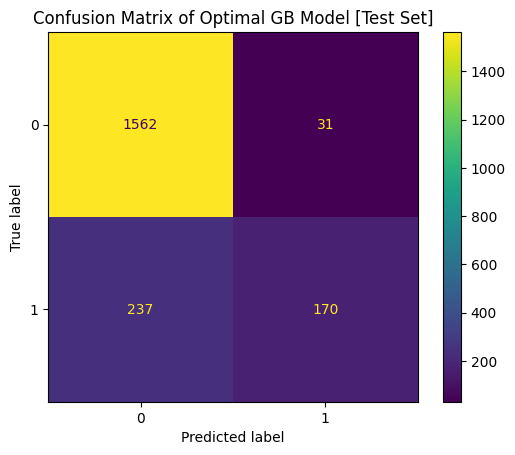

In [211]:
plot_confusion_matrix(gb_pipeline, "Optimal GB", X_test, y_test)

#### Add kmeans features to GB model

In [212]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion

In [213]:
kmean_pipe = make_pipeline(
    category_transformer,
    StandardScaler(),
    KMeans(4, random_state=42)
)

In [214]:
feat_union = FeatureUnion(
    [
        ("base_feat", category_transformer),
        ("kmeans_feat", kmean_pipe),
    ],
    verbose_feature_names_out=False
)

In [215]:
gb_kmeans_pipeline = make_pipeline(
    feat_union,
    gb_model
)

In [279]:
gb_kmeans_pipeline.fit(X_train, y_train)

,steps,"[('featureunion', ...), ('gradientboostingclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformer_list,"[('base_feat', ...), ('kmeans_feat', ...)]"
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False
,categories,'auto'
,drop,'if_binary'


#### Evaluate the training set

In [217]:
gb_train_errors = get_errors(gb_kmeans_pipeline, X_train, y_train)
gb_train_errors

{'accuracy': 0.881625,
 'recall': 0.4803680981595092,
 'precision': 0.8867497168742922}

#### Evaluate with cross validation

In [218]:
cv_results = cross_validate(gb_kmeans_pipeline, X_train, y_train, scoring=["accuracy", "precision", "recall"], cv=5, n_jobs=-1)
gb_avg_cv_errors = get_avg_cv_errors(cv_results)
gb_avg_cv_errors

{'accuracy': np.float64(0.860375),
 'recall': np.float64(0.4220858895705521),
 'precision': np.float64(0.799292607373037)}

#### Evaluate on test

In [219]:
gb_test_errors = get_errors(gb_kmeans_pipeline, X_test, y_test)
gb_test_errors

{'accuracy': 0.864, 'recall': 0.42997542997543, 'precision': 0.813953488372093}

#### Log errors

In [220]:
log_error("Opt GB+KM Model", gb_train_errors.values(), "train", perf_df)
log_error("Opt GB+KM Model", gb_avg_cv_errors.values(), "cv", perf_df)
log_error("Opt GB+KM Model", gb_test_errors.values(), "test", perf_df)

In [221]:
perf_df

,train_accuracy,train_recall,train_precision,cv_accuracy,cv_recall,cv_precision,test_accuracy,test_recall,test_precision
Base Model,0.79625,0.0,0.0,0.79625,0.0,0.0,0.7965,0.0,0.0
LR Model,0.81,0.213497,0.593857,0.810375,0.215951,0.596101,0.8085,0.186732,0.59375
DT Model,0.868125,0.459509,0.811484,0.856125,0.404294,0.782881,0.8595,0.44226,0.769231
RF Model,0.867,0.399387,0.884511,0.857875,0.383436,0.826891,0.8605,0.373464,0.863636
GB Model,0.923625,0.672393,0.934356,0.859875,0.479755,0.742064,0.8625,0.476658,0.757812
Opt GB Model,0.878375,0.466258,0.880649,0.861,0.419632,0.804738,0.866,0.41769,0.845771
Opt GB+KM Model,0.881625,0.480368,0.88675,0.860375,0.422086,0.799293,0.864,0.429975,0.813953


## Plot Confusion Matrix of GB_KM model

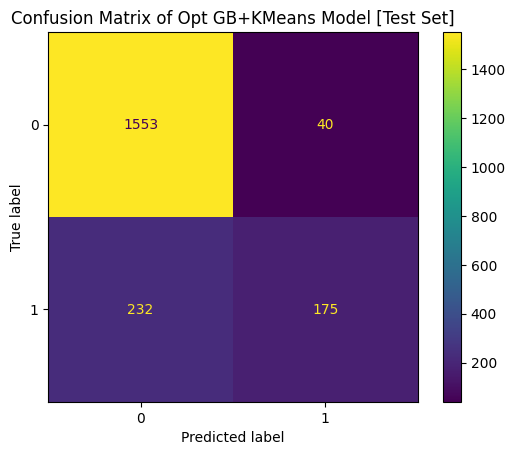

In [222]:
plot_confusion_matrix(gb_kmeans_pipeline, "Opt GB+KMeans", X_test, y_test)

## Visualize feature importance

In [223]:
feat_imps = pd.Series(
    gb_kmeans_pipeline[-1].feature_importances_,
    index=gb_kmeans_pipeline[-1].feature_names_in_,
).sort_values()

In [224]:
def clean_feats_name(feature):
    if "__" in feature:
        return feature[feature.index("__")+2:]
    return feature

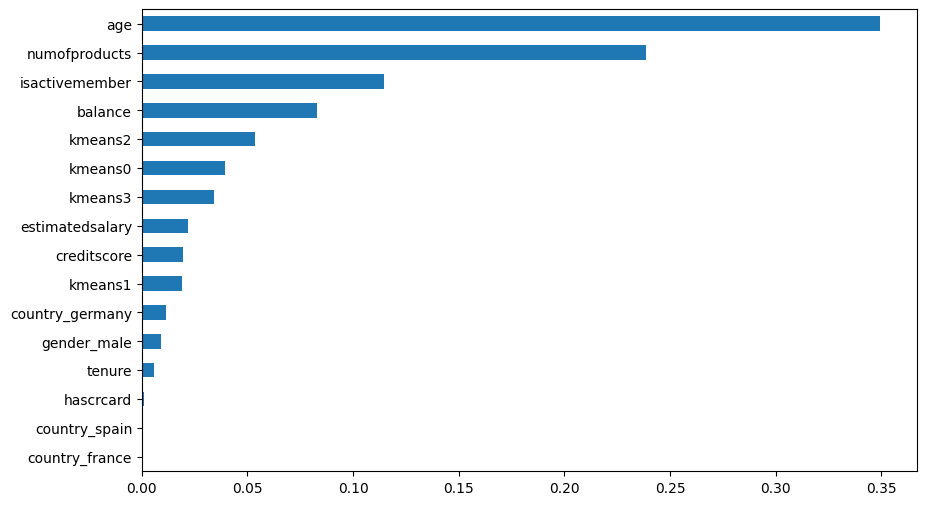

In [225]:
ax = feat_imps.plot(kind="barh", figsize=(10, 6))
ax.set_yticklabels(feat_imps.index.map(clean_feats_name));

Age and number of products seems to be the most significant feature for determing customers who are likely to leave.Three of the KMeans distance feature seems to be significant in determining if a customer will churn

## Handle class imbalance

## Plot precision recall curve

In [226]:
from sklearn.metrics import precision_recall_curve

In [227]:
precision, recall, thresholds = precision_recall_curve(y_test, gb_kmeans_pipeline.predict_proba(X_test)[:, 1])

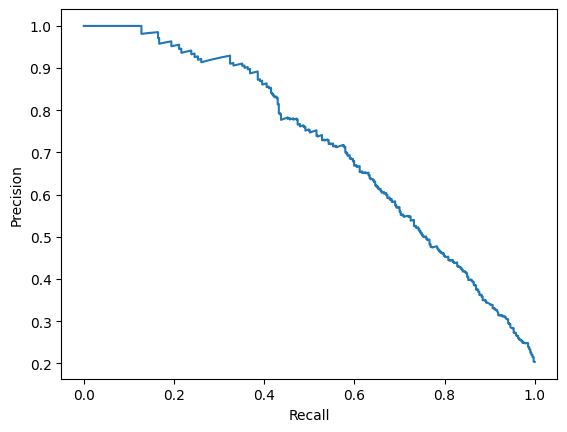

In [228]:
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision");

## Find optimal probability threshold

In [229]:
from sklearn.model_selection import TunedThresholdClassifierCV

In [280]:
ttcv = TunedThresholdClassifierCV(gb_kmeans_pipeline, cv=5, n_jobs=-1)
ttcv.fit(X_train, y_train)

,estimator,Pipeline(step...m_state=42))])
,scoring,'balanced_accuracy'
,response_method,'auto'
,thresholds,100
,cv,5
,refit,True
,n_jobs,-1
,random_state,None
,store_cv_results,False
,transformer_list,"[('base_feat', ...), ('kmeans_feat', ...)]"
,n_jobs,None


### Get train error

In [281]:
ttcv_train_error = get_errors(ttcv, X_train, y_train)
ttcv_train_error

{'accuracy': 0.813625,
 'recall': 0.8294478527607362,
 'precision': 0.5270955165692007}

#### Evaluate with cross validation

In [283]:
ttcv_results = cross_validate(
    ttcv, X_train, y_train, scoring=["accuracy", "precision", "recall"], cv=5, n_jobs=-1
)
ttcv_cv_errors = get_avg_cv_errors(cv_results)
ttcv_cv_errors

KeyError: 'test_accuracy'

### Get test error

In [ ]:
ttcv_test_error = get_errors(ttcv, X_test, y_test)
ttcv_test_error

In [ ]:
plot_confusion_matrix(
    ttcv, "Tuned Threshod GB+KM Model", X_test, y_test
)

#### Log errors

In [ ]:
log_error("Opt GB+KM+TTCV Model", ttcv_train_error.values(), "train", perf_df)
log_error("Opt GB+KM+TTCV Model", ttcv_cv_errors.values(), "cv", perf_df)
log_error("Opt GB+KM+TTCV Model", ttcv_test_error.values(), "test", perf_df)

In [ ]:
perf_df

### Retrain on whole dataset

In [ ]:
ttcv.fit(X, y)

In [ ]:
get_errors(ttcv, X, y)

### Save the model

In [ ]:
import joblib

In [ ]:
joblib.dump(ttcv, "../models/churn_model_v1.pkl")

### Load and test the model

In [ ]:
model = joblib.load("../models/churn_model_v1.pkl")

In [ ]:
get_errors(model, X, y)